# Stock Price Forecasting
This notebook demonstrates forecasting stock prices using ARIMA, SARIMA, Prophet, and LSTM models.

[*********************100%***********************]  1 of 1 completed


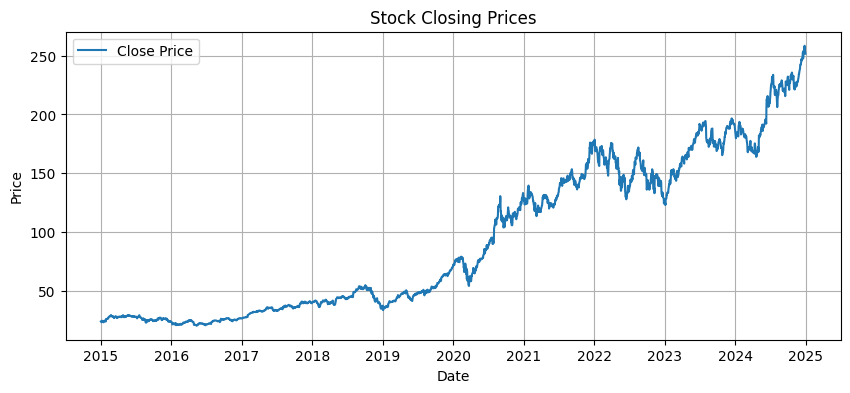

17:23:01 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0201
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8110e-04
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8437e-04
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8828e-04
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.5949e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📊 MODEL EVALUATION RESULTS
ARIMA    → RMSE: 69.62, MAE: 63.64
SARIMA   → RMSE: 55.16, MAE: 50.54
Prophet  → RMSE: 38.77, MAE: 31.86
LSTM     → RMSE: 10.99, MAE: 9.01


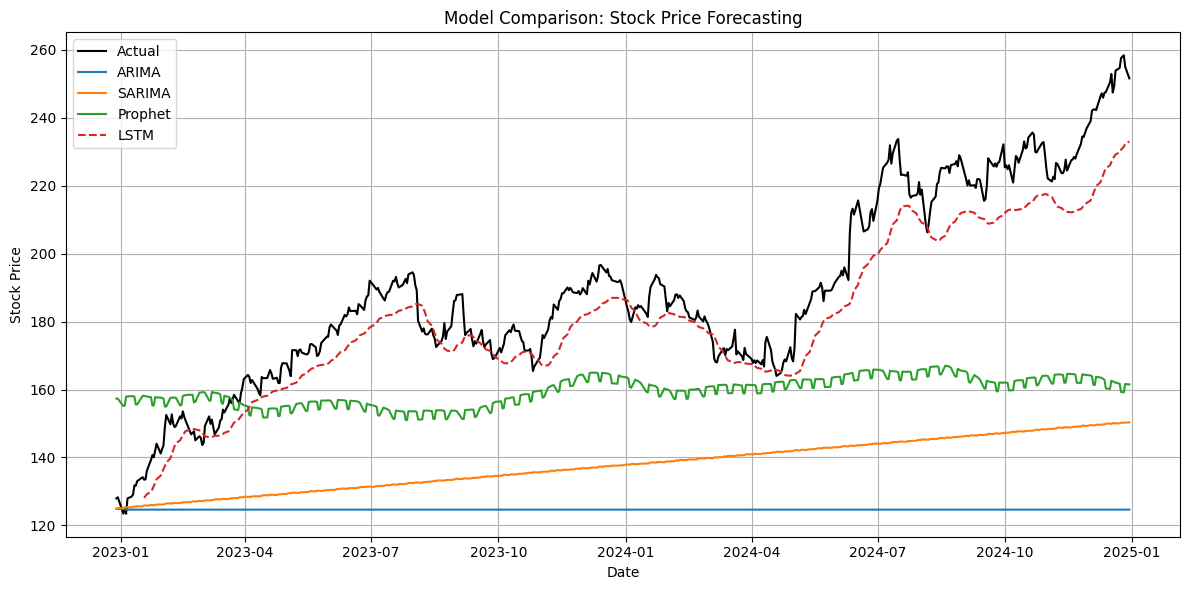

In [ ]:
# 📦 Step 1: Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# 📊 Step 2: Load Data
def load_stock_data(ticker="AAPL", start="2015-01-01", end="2024-12-31"):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].dropna()
    return df

df = load_stock_data()

# 📈 Step 3: Visualization
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title("Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

# ⚙️ Step 4: Evaluation Metrics
def evaluate(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# 🧪 Step 5: Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# 📉 ARIMA Model
def arima_forecast(train, test):
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

arima_pred = arima_forecast(train, test)
arima_rmse, arima_mae = evaluate(test['Close'], arima_pred)

# 🔁 SARIMA Model
def sarima_forecast(train, test):
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

sarima_pred = sarima_forecast(train, test)
sarima_rmse, sarima_mae = evaluate(test['Close'], sarima_pred)

# 🔮 Prophet Model
def prophet_forecast(df, steps):
    # Ensure the input has a 'Close' column and a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")

    if 'Close' not in df.columns:
        raise ValueError("DataFrame must contain a 'Close' column")

    # Create a Prophet-compatible DataFrame
    df_prophet = pd.DataFrame({
        'ds': df.index,
        'y': df['Close'].values.reshape(-1)

    })

    # Drop any NaNs
    df_prophet.dropna(subset=['y'], inplace=True)

    # Fit Prophet
    model = Prophet()
    model.fit(df_prophet)

    # Forecast
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)

    return forecast['yhat'][-steps:].values



prophet_pred = prophet_forecast(train, len(test))
prophet_rmse, prophet_mae = evaluate(test['Close'], prophet_pred)



# 🧠 LSTM Model
def lstm_forecast(df, steps):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

    pred_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(pred_scaled)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    return predictions.flatten(), actual.flatten()

lstm_pred, lstm_actual = lstm_forecast(df, len(test))
lstm_rmse, lstm_mae = evaluate(lstm_actual, lstm_pred)

# 📊 Summary
print("\n📊 MODEL EVALUATION RESULTS")
print(f"ARIMA    → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"SARIMA   → RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet  → RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")
print(f"LSTM     → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

# 📉 Plot Forecasts
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA')
plt.plot(test.index, sarima_pred, label='SARIMA')
plt.plot(test.index, prophet_pred, label='Prophet')
plt.plot(test.index[-len(lstm_pred):], lstm_pred, label='LSTM', linestyle='--')
plt.title("Model Comparison: Stock Price Forecasting")
plt.xlabel("Date")      
plt.ylabel("Stock Price")
